# Community Model
We want to combine all 7 bacterial species into one big community model, where bacteria exchange metabolites. This is important to analyse how they interact which each other reagrding e.g. cross-feeding

# Imports and Load Individual Models

In [1]:
# basic
import pandas as pd
import numpy as np
import os
import re

#
from functions import *

# cobra & micom
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import flux_variability_analysis, pfba
from cobra.medium import minimal_medium
from cobra.exceptions import Infeasible, OptimizationError
from cobra import Reaction
from micom import Community
from micom.problems import cooperative_tradeoff
from micom.workflows import tradeoff
# plot
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import seaborn as sns
import matplotlib.colors as mcolors
from sqlalchemy.sql.coercions import expect
from upsetplot import UpSet, from_indicators
# from pyvis.network import Network
# Clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Ändert das Anzeigeformat der Gleitkommazahlen
pd.options.display.float_format = '{:.5f}'.format

In [3]:
# Load SBML Models
models_path = "../Models/10_duplicate_removal/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


In [3]:
# Load SBML Models
models_path = "../Models/12_gap_filled/"
models_filled = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3]+"f")
    models_filled[name] = model

models_filled = {key: models_filled[key] for key in sorted(models_filled.keys())}  # sorts the dictionary alphabetically
AA1f, AA2f, AA3f, AA4f, AA5f, AA6f, AA7f = [models_filled[f"AA{i}f"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


In [99]:
# Load well established models for compariso
ecoli = read_sbml_model("../Models/iML1515.xml")
ecoli.solver = "cplex"
pseudo = read_sbml_model("../Models/iJN1463.xml")
pseudo.solver = "cplex"

In [31]:
def get_amounts(model):
    rxns = len(model.reactions)
    mets = len(model.metabolites)
    print(f"{model.id} has {rxns} reactions and {mets} metabolites")

In [37]:
for model in models.values():
    get_amounts(model)

AA1 has 2261 reactions and 1513 metabolites
AA2 has 2668 reactions and 1788 metabolites
AA3 has 2222 reactions and 1500 metabolites
AA4 has 2795 reactions and 1757 metabolites
AA5 has 2107 reactions and 1446 metabolites
AA6 has 2578 reactions and 1685 metabolites
AA7 has 2521 reactions and 1654 metabolites


In [33]:
for model in models_filled.values():
    get_amounts(model)

AA1 has 2261 reactions and 1513 metabolites
AA2 has 2668 reactions and 1788 metabolites
AA3 has 2222 reactions and 1500 metabolites
AA4 has 2795 reactions and 1757 metabolites
AA5 has 2112 reactions and 1447 metabolites
AA6 has 2578 reactions and 1685 metabolites
AA7 has 2521 reactions and 1654 metabolites


In [8]:
set([rxn.id for rxn in AA5f.reactions]) - set([rxn.id for rxn in AA5.reactions])
# make sure that reactions were added to the gap filled model but no artefacts remain (like sink reactions from testing gap filling)

{'ACGS', 'G1PACT', 'PGAMT'}

# Functions

In [5]:
def check_early_biomass_component(model, medium_dict, check_rxn_id):
    rxn_id = "objective_check"
    sad_mets = []

    check_mets = model.reactions.get_by_id(check_rxn_id).metabolites
    #check_mets = model.reactions.check_rxn_id.metabolites
    for met, flux in check_mets.items():
        if flux < 0: # only look at mets that are consumed
            #print(met)
            stoich = {met: flux}

            if rxn_id in model.reactions: # biomass test reaction is updated
                rxn = model.reactions.get_by_id(rxn_id)
                rxn.subtract_metabolites(rxn.metabolites)
                rxn.add_metabolites(stoich)
            else: # first time reaction is created
                new_rxn = Reaction(id=rxn_id, name="objective reaction", lower_bound=0, upper_bound=1000)
                new_rxn.add_metabolites(stoich)
                model.add_reactions([new_rxn])

            model.objective = rxn_id

            with model:
                change_medium(model, medium_dict)
                try:
                    pfba_flux = pfba(model)
                    if pfba_flux[rxn_id] == 0:
                        sad_mets.append(met.id)
                except Infeasible:
                    print("Cannot get result because pfba is infeasible")

    if rxn_id in model.reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        model.remove_reactions([rxn])

    print(sad_mets)

# Create Community Model
we want to combine our 7 models into one; they'll share one compartment where they can exchange metabolites.

In [20]:
for model in models.values():
    model.reactions.ATPM.lower_bound = 1
    model.reactions.ATPM.upper_bound = 1

## MICOM

with A7; if you run everything without changes we'll get infeasible flux solution; only if I change all lower bounds of all EXchange reactions to -1000 then we get a feasible solution (MICOM changed the lower bounds for all EX reactions that go from a bacterium into the medium to -100)

in comparison i tried the whole community model creation without AA7 and there it works directly without changing anything

In [9]:
taxonomy = pd.read_csv("../Datasets/community_model.csv", sep=";")
taxonomy

,id,genus,species,reactions,metabolites,file,abundance
0,AA1,Stenotrophomonas,Stenotrophomonas maltophilia,2261,1513,/home/lisa/Dokumente/Programmierung/Models/10_...,16
1,AA2,Brucella,Brucella pituitosa,2669,1789,/home/lisa/Dokumente/Programmierung/Models/10_...,5
2,AA3,Curtobacterium,Curtobacterium pusillum,2223,1501,/home/lisa/Dokumente/Programmierung/Models/10_...,8
3,AA4,Enterobacter,Enterobacter ludwigii,2795,1758,/home/lisa/Dokumente/Programmierung/Models/10_...,65
4,AA5,Chryseobacterium,Chryseobacterium indologenes,2107,1446,/home/lisa/Dokumente/Programmierung/Models/10_...,1
5,AA6,Herbaspirillum,Herbaspirillum robiniae,2578,1685,/home/lisa/Dokumente/Programmierung/Models/10_...,2
6,AA7,Pseudomonas,Pseudomonas putida,2522,1655,/home/lisa/Dokumente/Programmierung/Models/10_...,3


I talked with Nadine in my meeting on the 06 June and we decided that at the beginning we're not going to use abundances

In [9]:
# without abundance
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

Output()

In [10]:
# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

### Community with gap filled models

In [6]:
taxonomy_gap_filled = pd.read_csv("../Datasets/community_model_gap_filled.csv", sep=";")
syncom_filled = Community(taxonomy_gap_filled.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

Output()

In [7]:
# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom_filled.reactions.query("^EX_"):
    rxn.lower_bound = -1000

## Evaluate Syncom

In [21]:
syncom_EX = syncom.reactions.query("^EX_")
print(f"My syncom has in total {len(syncom_EX)} EX reactions.")

My syncom has in total 2571 EX reactions.


In [ ]:
total_EX = 0
for model in models.values():
    EX = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_")]
    total_EX += len(EX)
    print(f"Model {model.id} has {len(EX)} EX reactions.")
print(f"That means there are in total {total_EX} EX reactions in my 7 models.")

syncom_nonM_EX = [rxn for rxn in syncom.reactions.query("^EX_") if not rxn.id.endswith("m")]
print(f"There are {len(syncom_nonM_EX)} EX reactions from my models into shared medium in the syncom.")

In [ ]:
all_EX = set()
for model in models.values():
    EX = [rxn.id for rxn in model.reactions if rxn.id.startswith("EX_")]
    all_EX.update(EX)
print(f"There are {len(all_EX)} unique EX reactions in my 7 models.", )

EX_syncom_m = [rxn for rxn in syncom.reactions.query("^EX_") if rxn.id.endswith("m")]
print(f"There are {len(EX_syncom_m)} EX reactions from/into _m in my syncom.", )

In [ ]:
trimmed_all_EX = {s[:-2] for s in all_EX}  # assuming all_EX is a set of strings
trimmed_EX_syncom_m = {rxn.id[:-2] for rxn in EX_syncom_m}  # handle Reaction objects

diff = trimmed_all_EX - trimmed_EX_syncom_m
diff

In [ ]:
diff = trimmed_EX_syncom_m - trimmed_all_EX
diff

In [ ]:
syncom.reactions.query("EX_acon_C")

In [ ]:
for rxn in syncom.reactions.query("^EX_"):
    print(rxn.id[len(rxn.id)-3:], rxn.lower_bound)

### Micom Test Data

In [ ]:
from micom.data import test_taxonomy

taxonomy_test = test_taxonomy()
taxonomy_test

In [ ]:
from micom import Community

com = Community(taxonomy_test)

In [ ]:
from micom.data import test_db
from micom.data import test_data

data = test_data()
data

In [ ]:
taxonomy = pd.read_csv("../Datasets/community_model_build.csv", sep=";")

In [ ]:
from micom.workflows import build
manifest = build(taxonomy=taxonomy, out_folder="../", cutoff=0.0001, threads=2, model_db=None, solver="cplex")

In [ ]:
mre_jin = pd.read_csv("../Datasets/Medium/medium_ARE_Jin.csv", sep=";")

In [ ]:
medium_mre_m9 = pd.concat([m9, mre_jin], ignore_index=True)

In [ ]:
from micom.workflows import grow
res = grow(manifest, model_folder="../", medium=medium_mre_m9, tradeoff=0.5, threads=2)

In [ ]:
print(com.objective.expression)
com.optimize()

In [ ]:
sol = com.cooperative_tradeoff(fraction=1.0)
sol

In [ ]:
com

## PyCoMo
wir bleiben bei MICOM, da das mehr etabliert ist

In [ ]:
from pathlib import Path
import sys
import cobra
import os

In [ ]:
path_root = "/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/pycomo-0.2.8.dist-info"
sys.path.append(path_root)
import pycomo
pycomo.configure_logger(level="INFO")

In [ ]:
test_model_dir = "../Models/10_duplicate_removal"
# needed to change solver to cplex
named_models = pycomo.load_named_models_from_dir(test_model_dir)

In [ ]:
for model in named_models.values():
    print(model.objective)

In [ ]:
single_org_models = []
for name, model in named_models.items():
    print(name)
    single_org_model = pycomo.SingleOrganismModel(model, name)
    single_org_models.append(single_org_model)

In [ ]:
community_name = "lisas_endless_pain"
com_model_obj = pycomo.CommunityModel(single_org_models, community_name)

In [ ]:
com_model_obj.model

In [ ]:
# at the moment there is a fixed grwoth but with variable abundance
com_model_obj.summary()

In [ ]:
# we can change the simulation that we have set abundance and variable grwoth (like it should be)
com_model_obj.convert_to_fixed_abundance()
abundance_dict = com_model_obj.generate_equal_abundance_dict()
com_model_obj.apply_fixed_abundance(abundance_dict)
com_model_obj.summary()

# Medium

In [11]:
def change_medium_bounds(medium_df, carbon_bound, non_carbon_bound=1000):
    if not isinstance(medium_df, pd.DataFrame):
        return "please df :c"

    medium_df = medium_df.copy()

    medium_df["bound"] = np.where(
    medium_df["reaction"].isin(m9_rxn),
        non_carbon_bound,   # value if reaction is in m9_rxn
        carbon_bound)       # value if not

    return medium_df

## M9

In [10]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")

In [11]:
m9_rxn = list(m9["reaction"])

## Maize Root Exudate

In [17]:
# based on https://pmc.ncbi.nlm.nih.gov/articles/PMC5726377/pdf/EJSS-68-806.pdf
mre_naveed = pd.read_csv("../Datasets/Medium/medium_MRE_Naveed.csv", sep=";")

In [18]:
mre_krumbach = pd.read_csv("../Datasets/Medium/medium_MRE_Krumbach.csv", sep=";")
# this is the more core medium

In [ ]:
# this is the very extensive list of metabolites from LC-MS aka table s1
og_medium = pd.read_csv("../krumbach_og_medium.csv", sep=";", header=None)
print(len(set(og_medium[0])))
set(og_medium[0])

In [15]:
mre_jin = pd.read_csv("../Datasets/Medium/medium_MRE_Jin.csv", sep=";")

## Combined MARE & M9 with bounds

In [12]:
medium_combined_naveed = pd.read_csv("../Datasets/Medium/medium_combined_Naveed_M9.csv", sep=";", quotechar='"')
medium_combined_krumbach= pd.read_csv("../Datasets/Medium/medium_combined_Krumbach_M9.csv", sep=";", quotechar='"')

## Ashley Beck

In [15]:
medium_beck = pd.read_csv("../Datasets/Medium/medium_Beck.csv", sep=";")

## Ecoplate

In [13]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

# Medium comparison

In [19]:
set_jin = set(mre_jin["reaction"])
set_naveed = set(mre_naveed["reaction"])
set_krumbach = set(mre_krumbach["reaction"])

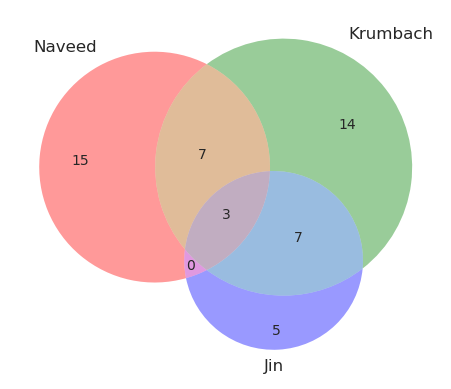

In [19]:
from matplotlib_venn import venn3
venn3((set_naveed, set_krumbach, set_jin), set_labels=('Naveed', 'Krumbach', 'Jin'))
plt.show()

In [20]:
# Create a union of all reactions
all_reactions = set_naveed | set_krumbach | set_jin

# Build a DataFrame showing presence (1) or absence (0) in each set
venn_df = pd.DataFrame({
    'reaction': list(all_reactions),
    'in_naveed': [1 if rxn in set_naveed else 0 for rxn in all_reactions],
    'in_krumbach': [1 if rxn in set_krumbach else 0 for rxn in all_reactions],
    'in_jin': [1 if rxn in set_jin else 0 for rxn in all_reactions]
})

# Simulations

In [22]:
all_models = {**models, 'Community': syncom}

In [14]:
all_models_filled = {**models_filled, 'Community': syncom_filled}

The limited version is when all the bacteria in the community actually share one medium, so they would only have 1/7 of the og medium.

## Growth on Maize ARE & M9

When comparing the Naveed and krumbach medium, there are especially differences in the community. Because with krumbach we see growth for AA1 which isn't the case for naveed. AA3 doesnt show growth at the moment in the individual models because of the low bounds for the carbon soirces in the medium.

In [ ]:
# there is definitely a difference between pfba and the cooperative tradeoff function from MICOM
# with pfba i dont have growth for aa1 and aa5 in the community, that is why when i first used the krumbach medium
# i kinda dismissed it because there wasnt really a change in comparison to naveed
# but now with the micom function there actually is
with syncom:
    chill_medium = change_medium_bounds(medium_combined_krumbach, 1000)
    change_medium(syncom, chill_medium)
    com_fluxes = pfba(syncom_filled).fluxes # funnily i get NO error with the syncom that is not filled but maybe that was luck

# gets you an error because of pFBA

In [26]:
for model in all_models_filled.values():
    growth_val = test_medium(model, medium_beck)
    print(model.id, ": ", growth_val)

AA1 :  4.357781605893641
AA2 :  14.158444923248128
AA3 :  1.6721018815020645
AA4 :  10.925028570494632
AA5 :  10.859117739184253
AA6 :  10.975139202528348
AA7 :  14.03441775282472
C7 :  model
AA1   14.62651
AA2   17.89780
AA3    3.48710
AA4   15.78198
AA5   20.16625
AA6   13.78563
AA7   14.90130
Name: Growth, dtype: float64


In [25]:
for model in all_models.values():
    chill_medium = change_medium_bounds(medium_beck, 200, non_carbon_bound=1000)
    growth_val = test_medium(model, chill_medium)
    print(model.id, ": ", growth_val)

AA1 :  0.0
AA2 :  23.363103231066148
AA3 :  8.408898203581192
AA4 :  39.94555916162176
AA5 :  0.0
AA6 :  28.51455181697144
AA7 :  27.19425311230267
C7 :  model
AA1   31.29966
AA2   38.39613
AA3   24.99789
AA4   43.23286
AA5    0.04155
AA6   43.14488
AA7   42.81015
Name: Growth, dtype: float64


In [16]:
for model in all_models_filled.values():
    print(test_medium(model, medium_combined_krumbach))

10.684004015899328
0.0
1.9584272055034475
16.735081796546574
12.546695393311563
15.041074253374257
15.5278721107666
model
AA1   17.87199
AA2   18.80990
AA3   14.67610
AA4   14.61263
AA5   15.02492
AA6   14.94007
AA7   15.20783
Name: Growth, dtype: float64


In [16]:
for model in all_models_filled.values():
    growth_val = test_medium(model, medium_combined_naveed)
    print(model.id, ": ", growth_val)

AA1 :  12.627834449630024
AA2 :  0.0
AA3 :  1.187837109963803
AA4 :  16.838073691204862
AA5 :  13.221138314579772
AA6 :  14.004710482938082
AA7 :  15.730749675525526
C7 :  model
AA1   12.59747
AA2   14.59677
AA3    0.00011
AA4   33.14038
AA5   19.32665
AA6   17.46808
AA7   21.45642
Name: Growth, dtype: float64


In [17]:
growth_ind_krumbach = []
growth_ind_naveed = []
growth_com_krumbach = []
growth_com_naveed = []
for model in all_models_filled.values():
    ### Krumbach
    growth_val = test_medium(model, medium_combined_krumbach, frac=1)
    if model.id == "C7":
        growth_com_krumbach = growth_val
    else:
        growth_ind_krumbach.append(growth_val)
    print(model.id, ": ", growth_val, "K")

    ### Naveed
    growth_val = test_medium(model, medium_combined_naveed, frac=1)
    if model.id == "C7":
        growth_com_naveed = growth_val
    else:
        growth_ind_naveed.append(growth_val)
    print(model.id, ": ", growth_val, "N")

AA1 :  10.684004015899331 K
AA1 :  12.627834449630019 N
AA2 :  0.0 K
AA2 :  0.0 N
AA3 :  1.9584272055034488 K
AA3 :  1.1878371099638008 N
AA4 :  16.735081796546574 K
AA4 :  16.838073691204862 N
AA5 :  12.546695393311563 K
AA5 :  13.221138314579646 N
AA6 :  15.04107425337435 K
AA6 :  14.004710482938158 N
AA7 :  15.5278721107666 K
AA7 :  15.730749675525526 N
C7 :  model
AA1   17.87257
AA2   18.78915
AA3   14.67616
AA4   14.65126
AA5   15.02212
AA6   14.94332
AA7   15.18875
Name: Growth, dtype: float64 K
C7 :  model
AA1   14.11988
AA2   14.59681
AA3    0.00055
AA4   30.66169
AA5   19.62920
AA6   18.29122
AA7   21.28701
Name: Growth, dtype: float64 N


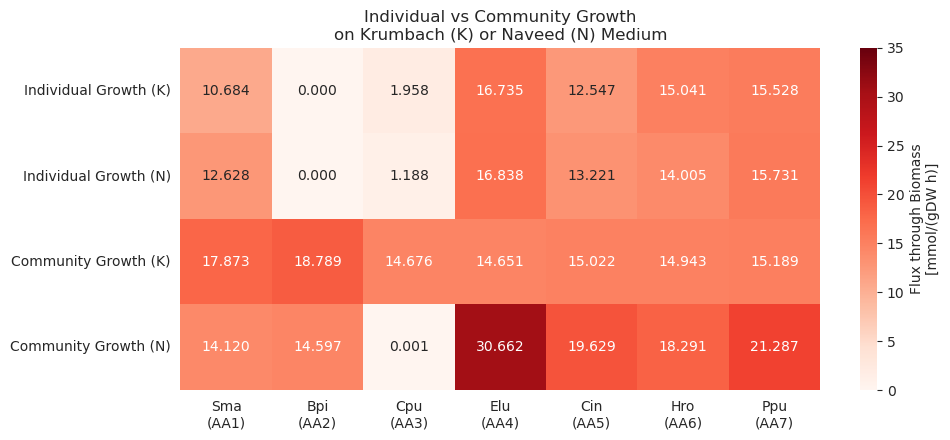

In [18]:
data = np.array([growth_ind_krumbach, growth_ind_naveed, list(growth_com_krumbach), list(growth_com_naveed)])
bac_names = ["Sma\n(AA1)", "Bpi\n(AA2)", "Cpu\n(AA3)", "Elu\n(AA4)", "Cin\n(AA5)", "Hro\n(AA6)", "Ppu\n(AA7)"]

df = pd.DataFrame(data,
                  index=["Individual Growth (K)", "Individual Growth (N)", "Community Growth (K)", "Community Growth (N)"],
                  columns=bac_names)

plt.figure(figsize=(10, 4.5))
sns.heatmap(df, annot=True, fmt=".3f", cmap="Reds", cbar_kws={'label': 'Flux through Biomass\n[mmol/(gDW h)]'},
            vmax=35)
plt.title("Individual vs Community Growth\non Krumbach (K) or Naveed (N) Medium")
plt.tight_layout()

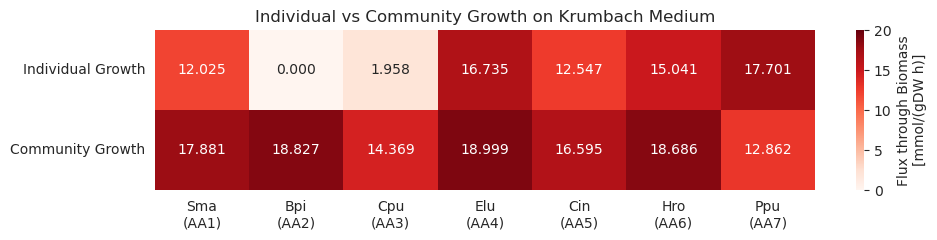

In [61]:
# Combine into 2D array for heatmap
growth_ind = [0 if x is None else x for x in growth_ind_krumbach]
data = np.array([growth_ind, list(growth_com_krumbach)])

#bac_names = ["AA1", "AA2", "AA3", "AA4", "AA5", "AA6", "AA7"]
#bac_names = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu"]
bac_names = ["Sma\n(AA1)", "Bpi\n(AA2)", "Cpu\n(AA3)", "Elu\n(AA4)", "Cin\n(AA5)", "Hro\n(AA6)", "Ppu\n(AA7)"]

# Create a DataFrame for better labeling
df = pd.DataFrame(data,
                  index=["Individual Growth", "Community Growth"],
                  columns=bac_names)

#tree_order = ["Cin", "Ppu", "Sma", "Elu", "Bpi", "Hro", "Cpu"]
#df = df[tree_order]  # Reorder columns

# Plot
plt.figure(figsize=(10, 2.5))
sns.heatmap(df, annot=True, fmt=".3f", cmap="Reds", cbar_kws={'label': 'Flux through Biomass\n[mmol/(gDW h)]'},
            vmax=20)
plt.title("Individual vs Community Growth on Krumbach Medium")
plt.tight_layout()
#plt.show()
#plt.savefig("../Figures/Biomass_Ind_Com_KrumbachMed.svg")

it is also important to note that for the community I really should use the cooperative tradeoff function from MICOM; normal pfba() gets me infeasible solution quite often

AA2 is able to grow within the community model although it was previously not able to grow on its own (nice!) AA2 needed thiamine to grow.

lets check AA2 within the community

In [ ]:
with syncom:
    change_medium(syncom, medium_mre_m9)
    c7 = pfba(syncom).fluxes

In [ ]:
c7[(c7.index.str.contains('Growth'))
   ]

In [ ]:
c7[(c7.index.str.startswith('EX_')) &
   (c7.index.str.endswith('_AA2')) &
   (c7 < 0)]

In [ ]:
# AA7 secretes thm into medium
c7[(c7.index.str.contains('thm_e')) &
    (c7 > 0)]

In [ ]:
with AA7:
    change_medium(AA7, medium_combined_krumbach)
    aa7 = pfba(AA7).fluxes

In [ ]:
aa7[(aa7.index.str.contains('thm_e'))]
# AA7 only secretes thm in the community, on its own, it doesnt do that

## Ecoplate Substrate Utilisation

In [19]:
metab_axis = ["Phenylethylamine", "Putrescine", "Glycyl-glutamic acid", "L-arginine", "Asparagine", "Phenylalanine", "Serine", "Threonine", "Glycerol-phosphate", "Cellobiose", "Mannitol", "Xylose", "Glucose-1-phosphate", "Acetyl-glucosamine", "4-Hydroxy benzoic acid", "Galacturonic acid", "Malic acid", "2-Hydroxy-benzoic acid", "Lactose", "Butyric acid", "Water (Control)"]

[08/13/25 15:19:30] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=914523;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=614340;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

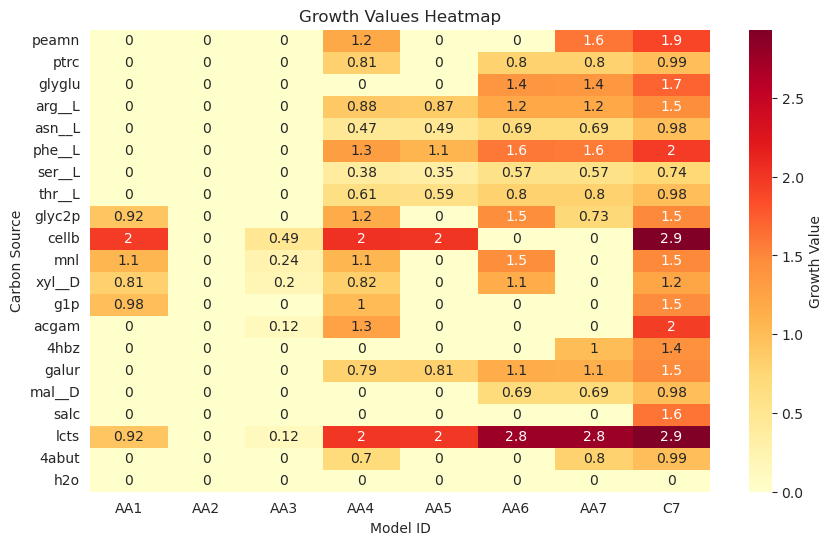

In [20]:
ecoplate_df = create_medium(ecoplate_rxns, m9_rxn, all_models_filled, 10, carbon_only=True)

In [22]:
# for nicer visualisation: better labels
ecoplate_df.index = metab_axis
ecoplate_df.columns = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu", "Community"]
ecoplate_df = ecoplate_df.fillna(0)

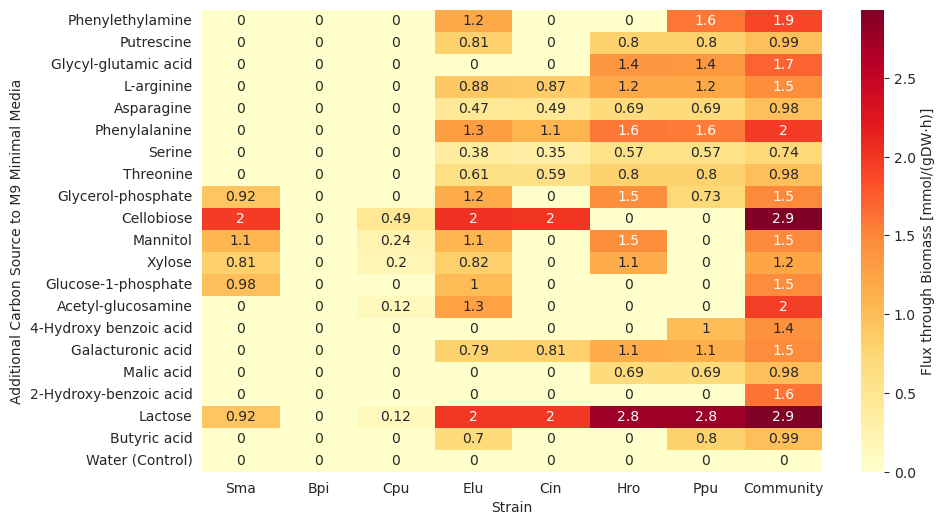

In [24]:
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ecoplate_df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'})
# plt.title("")
plt.xlabel("Strain")
#plt.yticks(ticks=np.arange(len(metab_axis)), labels=metab_axis)
plt.ylabel("Additional Carbon Source to M9 Minimal Media")
#plt.savefig("../Figures/ecoplate.svg", format="svg", bbox_inches="tight")
plt.show()


In [ ]:
# all reactions in the M9 have a bound of 1000, only bounds of carbon reactions are modified
# AA7 can grow with carbon sources <500, i.e. especially O2 is limiting (i saw that in other simulations, that o2 ans fructose were the ones with highest flux values)
create_medium(ecoplate_rxns, m9_rxn, all_models, 45, carbon_only=True)

## Growth on Different Carbon Sources

In [25]:
carbon_sources = ["EX_glc__D_e", "EX_sucr_e", "EX_xyl__D_e", ["EX_mal__L_e", "EX_mal__L_e"], "EX_pyr_e", "EX_succ_e", ["EX_ala__L_e", "EX_ala__L_e"], "EX_glu__L_e", "EX_gly_e"]

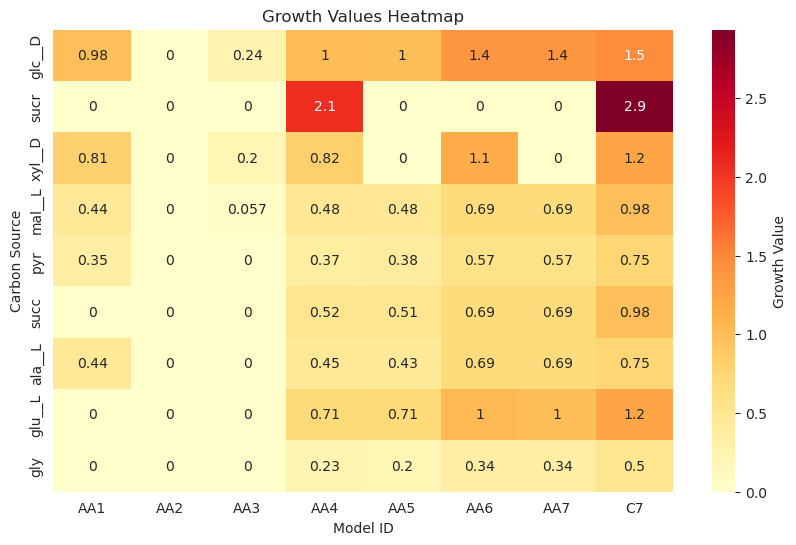

In [26]:
carbon_df = create_medium(carbon_sources, m9_rxn, all_models_filled, 10, carbon_only=True)

In [27]:
# nicer plot with nicer labels
carbon_df.index = ["Glucose", "Sucrose", "Xylose", "Malate", "Pyruvate", "Succinate", "Alanine", "Glutamate", "Glycine"]
carbon_df.columns = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu", "Community"]
carbon_df = carbon_df.fillna(0)

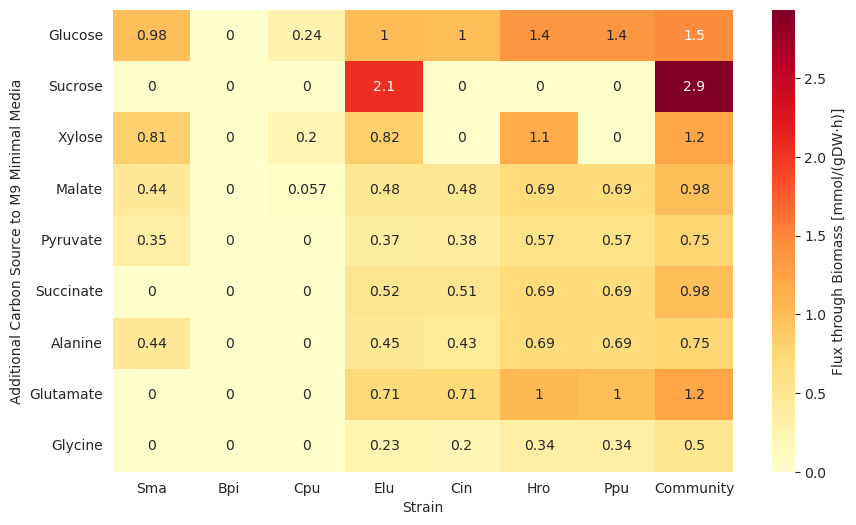

In [28]:
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(carbon_df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'})
# plt.title("")
plt.xlabel("Strain")
plt.ylabel("Additional Carbon Source to M9 Minimal Media")
#plt.savefig("../Figures/growth_diff_carbon_sources.svg", format="svg", bbox_inches="tight")
plt.show()

## Aufnahme und Abgabe

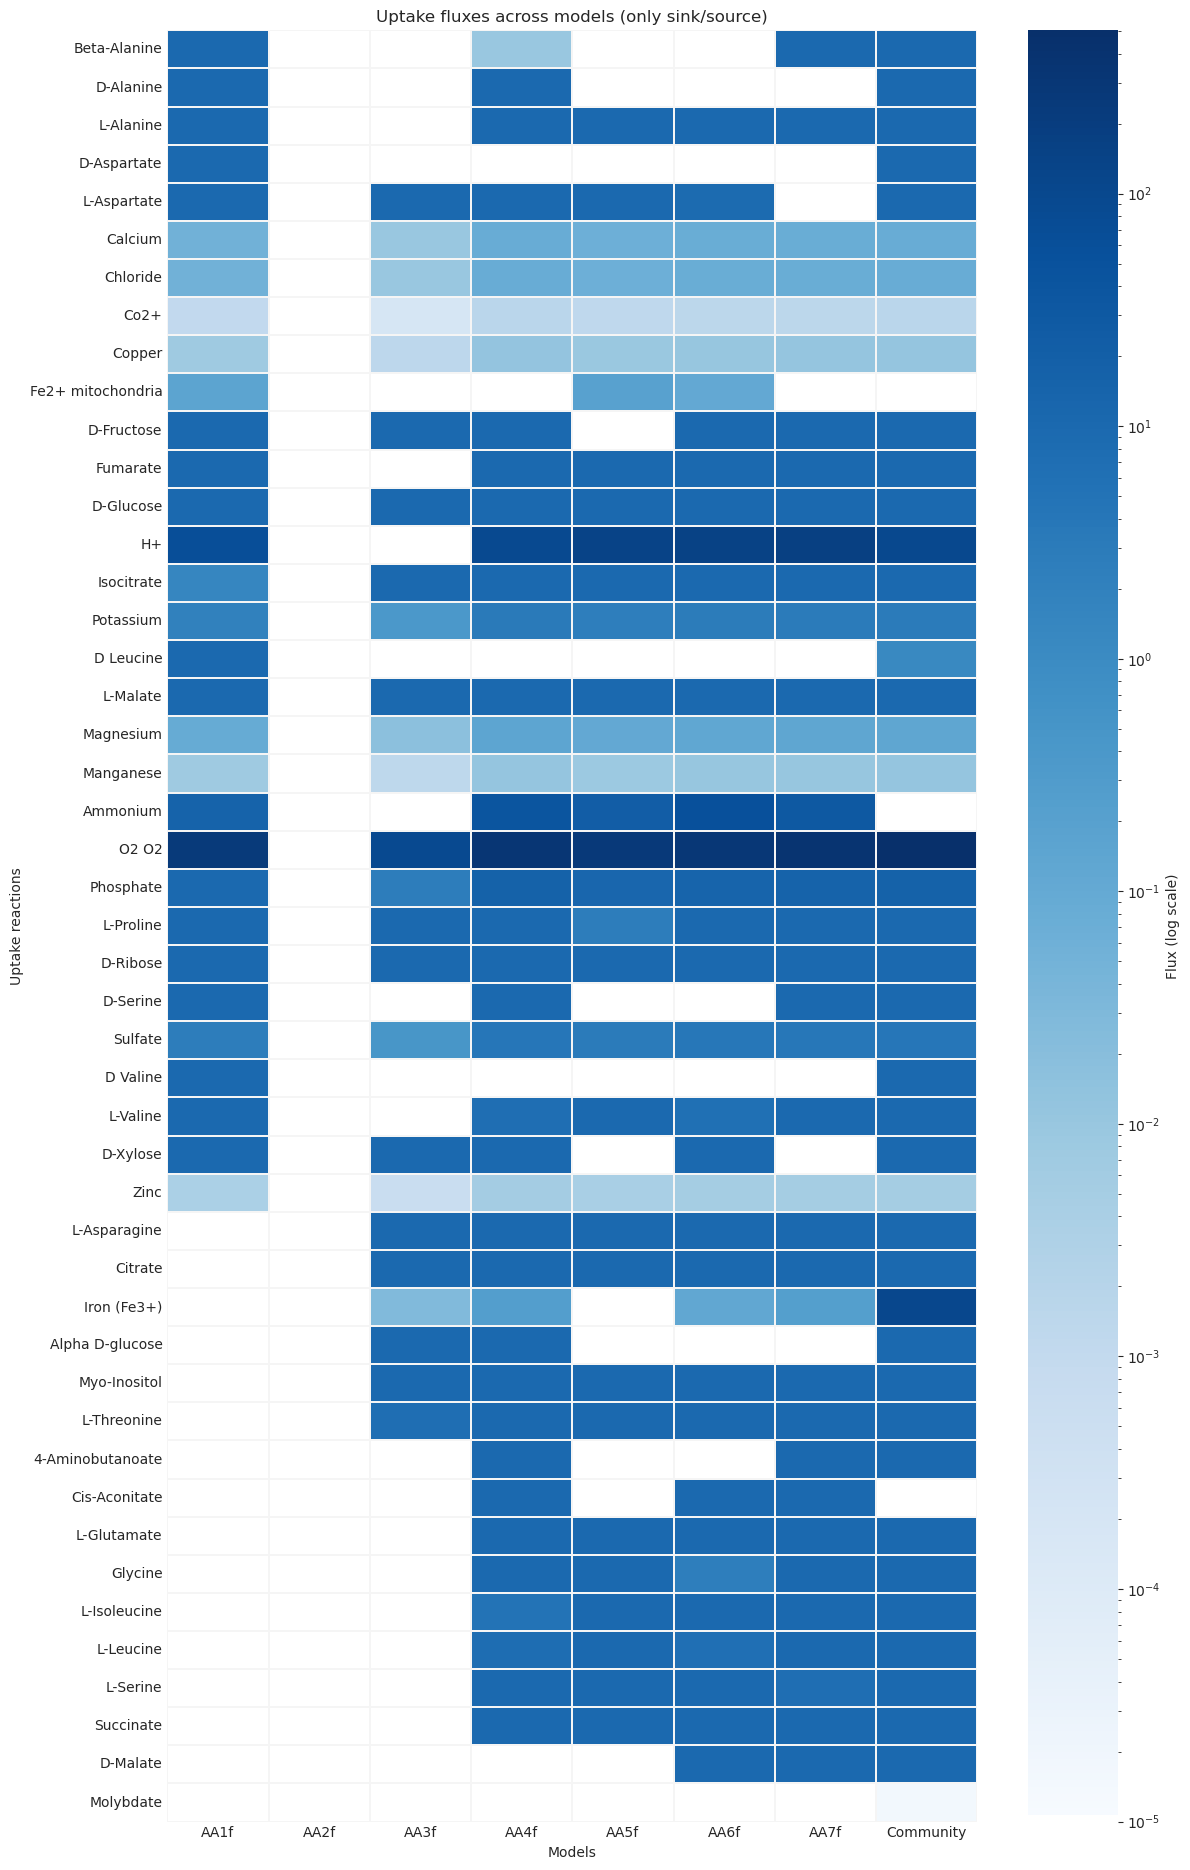

In [15]:
# the code for the community works in a way it only looks at EX reactions into/from the medium and outside and NO EX into/from a model into the medium
uptake_df = uptake_secret_heatmap(all_models_filled, "uptake", medium_combined_krumbach, c7_all_ex = "no")

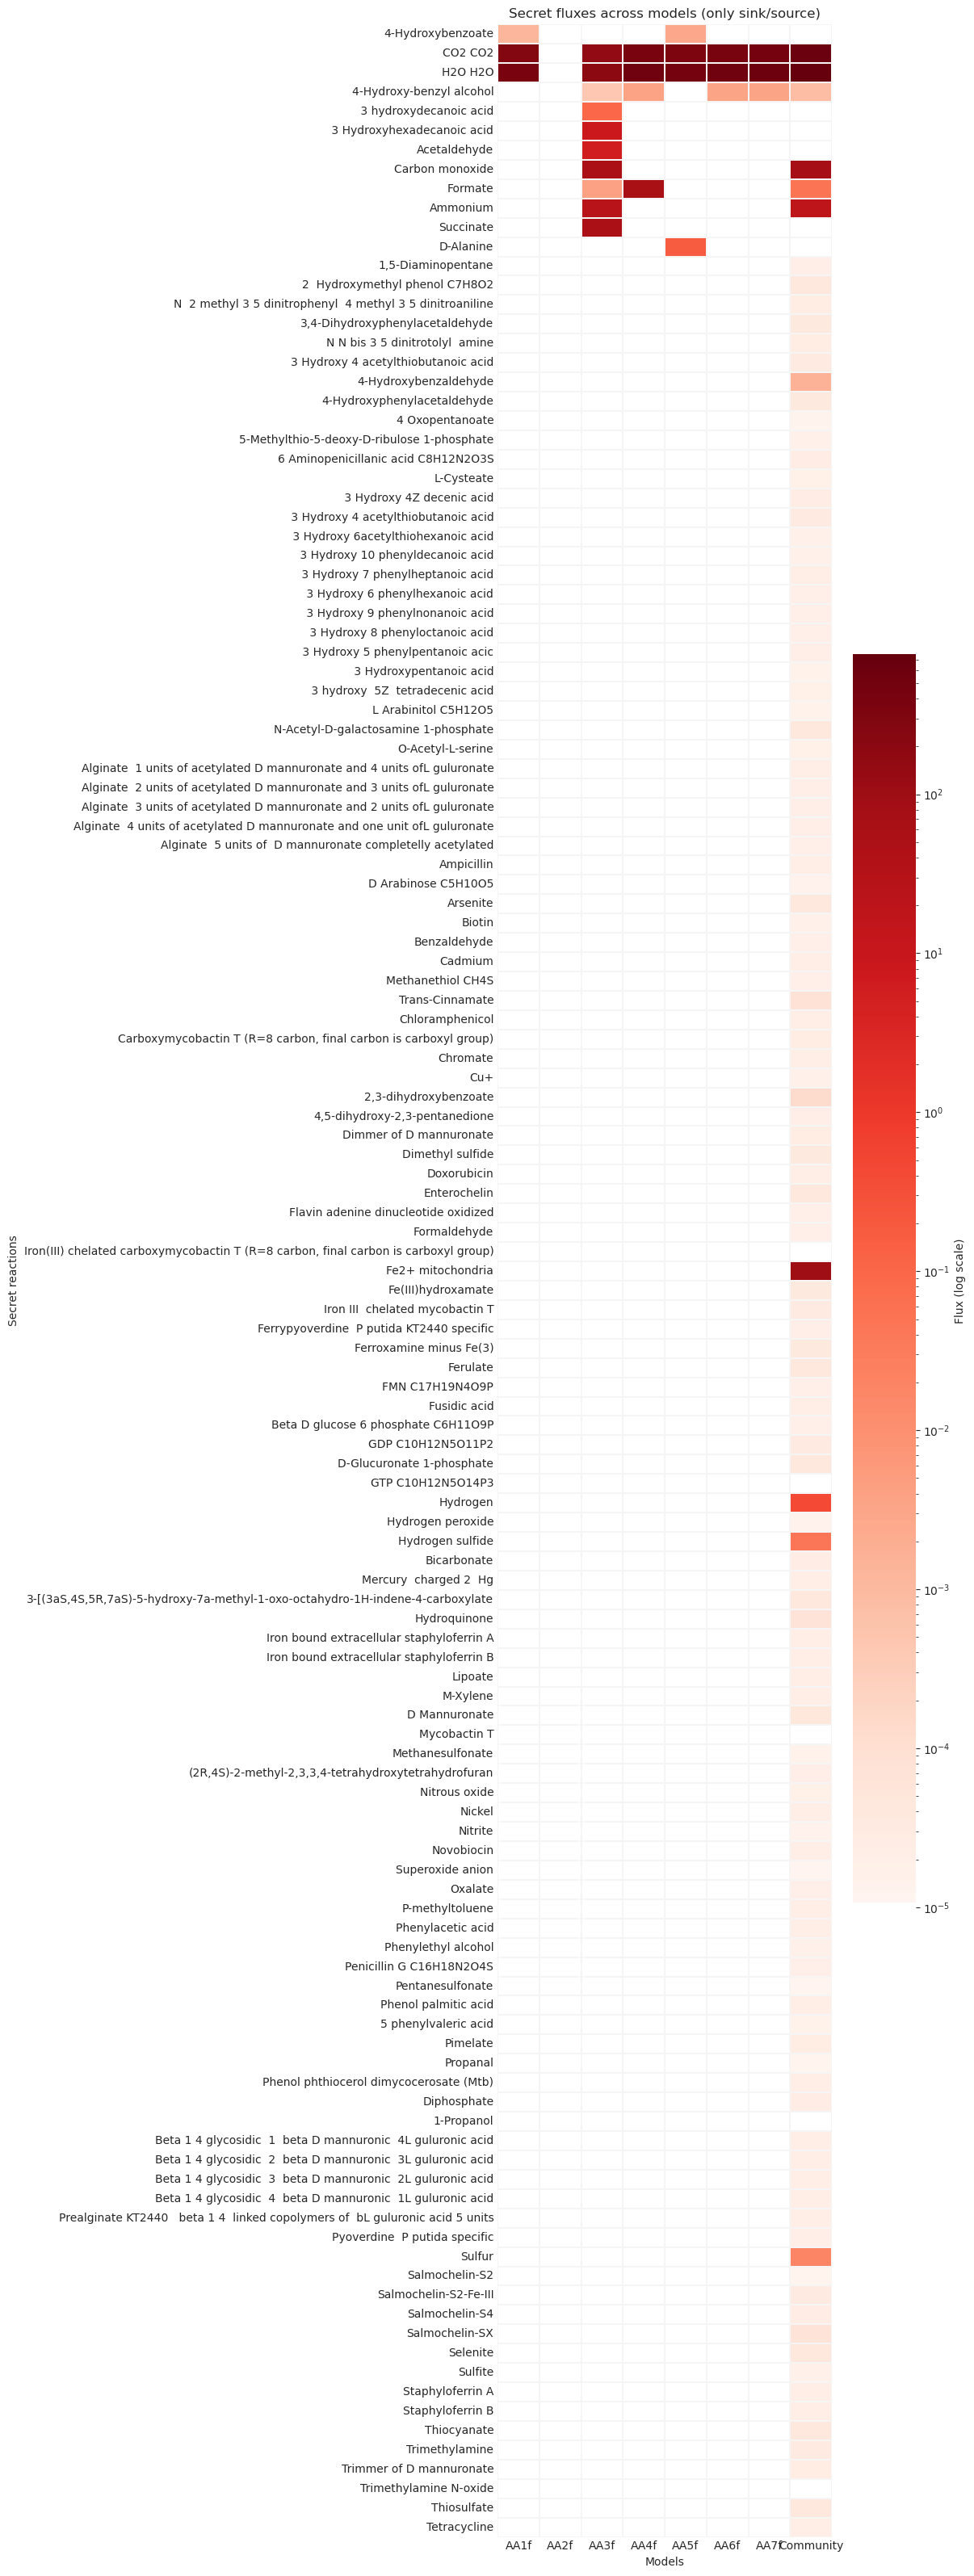

In [16]:
secretion_df = uptake_secret_heatmap(all_models_filled, "secret", medium_combined_krumbach, c7_all_ex = "no")

it may be interessting to see the metabolic niches of all my bacteria. but because some of them are not able to grow on their own, i would disregard the medium right now and maybe use the minimal medium for each of the bacteria determined by cobrapy.

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


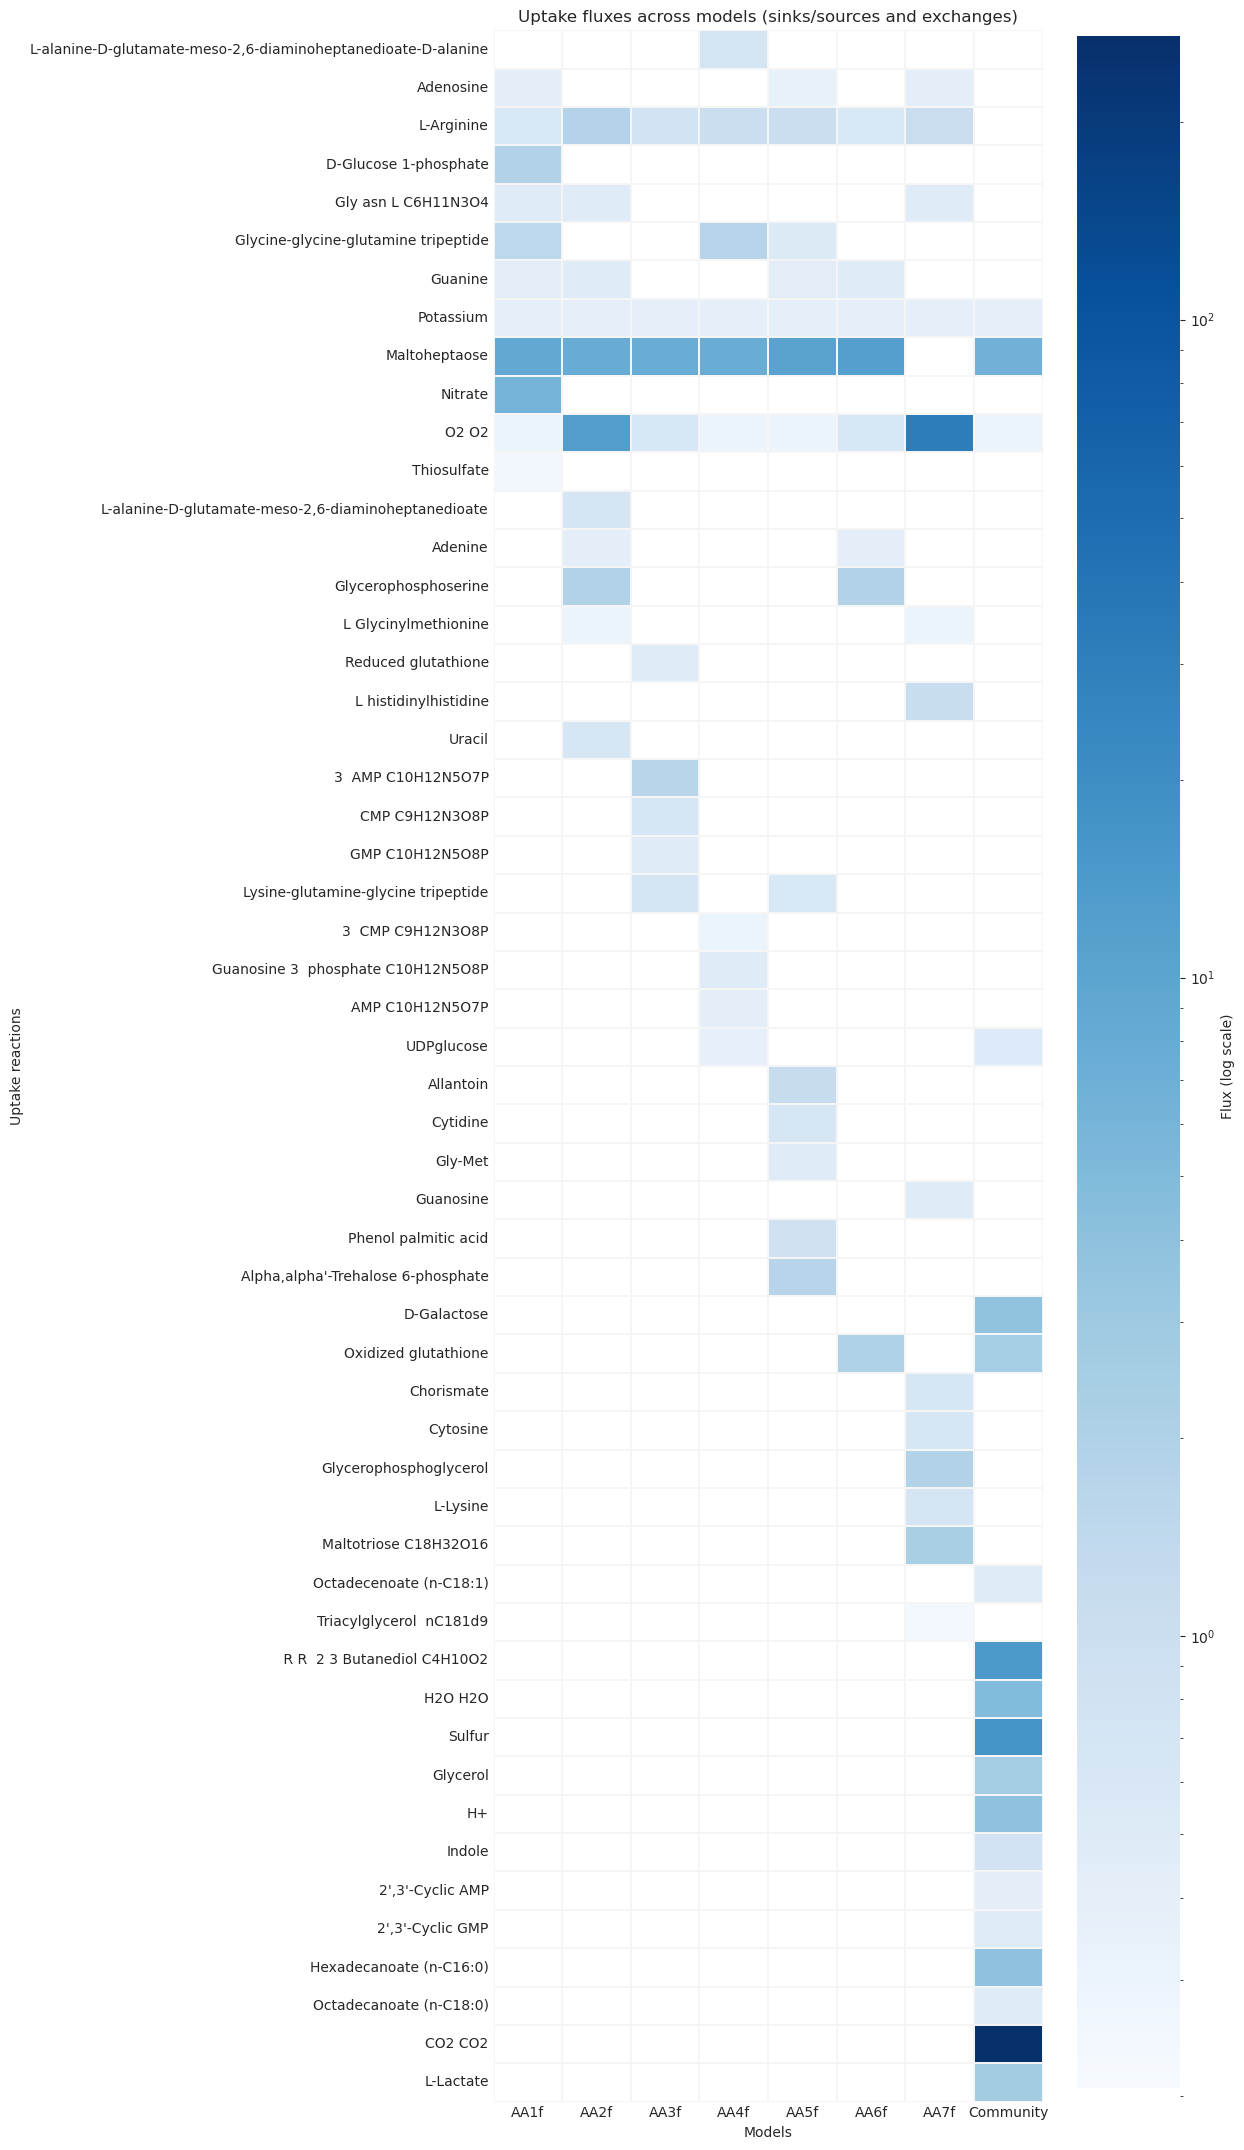

In [17]:
df_uptakes_all = uptake_secret_heatmap(all_models_filled, "uptake", c7_all_ex="yes", vmin=0.2)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


,AA1f,AA2f,AA3f,AA4f,AA5f,AA6f,AA7f,Community
Acetaldehyde,25.35679,22.50628,77.44983,NaN,19.78413,59.33137,NaN,16.70702
CO2 CO2,108.96876,107.49757,18.68950,63.41581,141.72318,116.54709,34.84621,55.50936
Ethanol,73.98308,74.34669,NaN,NaN,90.97840,97.85927,0.00000,15.89694
L-Lactate,8.26776,NaN,NaN,NaN,NaN,3.64476,NaN,0.00000
3 Hydroxyhexadecanoic acid,NaN,NaN,2.19870,NaN,NaN,NaN,NaN,0.00001
Carbon monoxide,NaN,NaN,84.80059,NaN,NaN,49.45587,NaN,46.38387
H2O H2O,NaN,NaN,64.97498,NaN,NaN,NaN,37.55406,0.00009
Succinate,NaN,NaN,0.32890,19.09603,NaN,NaN,NaN,5.66699
R R 2 3 Butanediol C4H10O2,NaN,NaN,NaN,36.86218,NaN,NaN,NaN,22.76665
Hydrogen,NaN,NaN,NaN,11.32129,NaN,NaN,NaN,29.62117


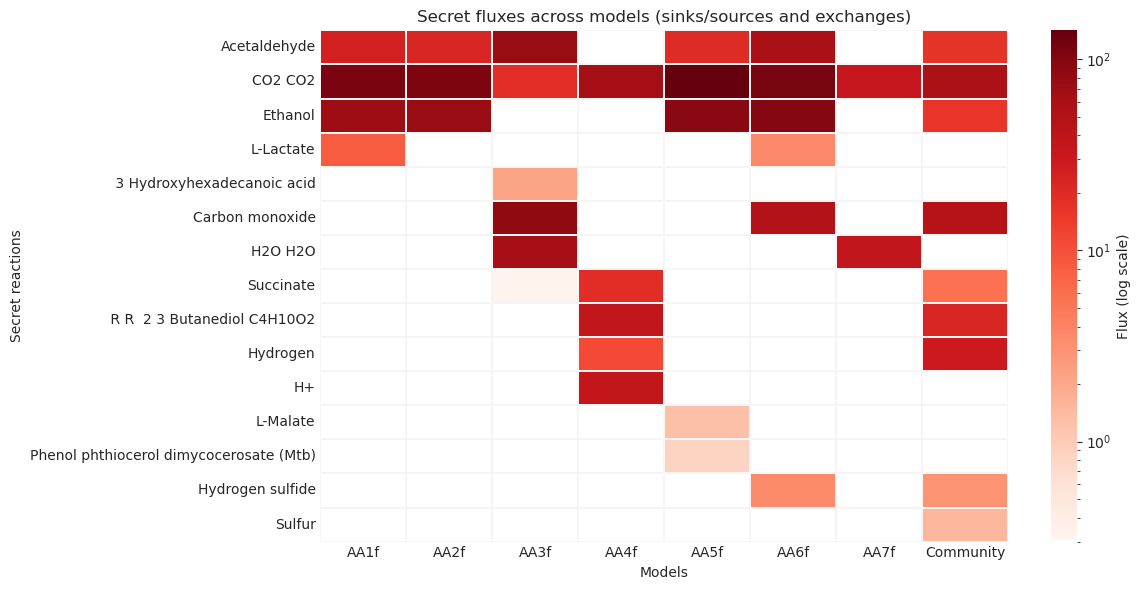

In [45]:
uptake_secret_heatmap(all_models_filled, "secret", c7_all_ex="yes", vmin=0.3)

I think the community lacks a bit of uptake because the above plots only check for uptake/secretion into the medium from the outside. all metabolites that are secreted and uptaken by the members are disregarded. however in the paper it is very likely that the would measure that as well because the medium compartment doesnt exist in RL

Get the Uptakes and Secretion Fluxes more in detail; Comparison between individual model and their behaviour in the community

In [ ]:
def compare_rxn_lists(com_index, single_index, model_id):
    # Convert to sets
    set1 = list(com_index)
    set2 = set(single_index)

    # Cut off the last 5 characters from each ID in list1
    set1 = set([rxn[:-5] for rxn in set1])

    # Reactions in both lists
    shared = set1 & set2  # or set1.intersection(set2)

    # unique reactions
    unique_to_list1 = set1 - set2
    unique_to_list2 = set2 - set1

    return shared, unique_to_list1, unique_to_list2

In [30]:
def get_uptake_secrets(model, medium, type):
    syncom_fluxes = get_pfba_fluxes(syncom, medium)
    single_flux = get_pfba_fluxes(model, medium)

    if type == "uptake":
        com_uptakes = syncom_fluxes[(syncom_fluxes.index.str.startswith('EX_')) &
                            (syncom_fluxes.index.str.endswith(f'_{model.id}')) &
                            (syncom_fluxes < 0)]
        single_uptakes = single_flux[(single_flux.index.str.startswith('EX_')) &
                        (single_flux < 0)]
    elif type == "secret":
        com_uptakes = syncom_fluxes[(syncom_fluxes.index.str.startswith('EX_')) &
                            (syncom_fluxes.index.str.endswith(f'_{model.id}')) &
                            (syncom_fluxes > 0)]
        single_uptakes = single_flux[(single_flux.index.str.startswith('EX_')) &
                        (single_flux > 0)]
    else:
        return "Specify either \"uptake\" or \"secret\" as type"

    shared, unique_to_com, unique_to_single = compare_rxn_lists(com_uptakes.index, single_uptakes.index, model.id)
    return shared, unique_to_com, unique_to_single


In [ ]:
uptake_single, uptake_com, uptake_shared, secret_single, secret_com, secret_shared = [], [], [], [], [], []

for model in models.values():
    up_shared, up_unique_to_com, up_unique_to_single = get_uptake_secrets(model, medium_mre_m9, "uptake")
    uptake_single.append(up_unique_to_single)
    uptake_com.append(up_unique_to_com)
    uptake_shared.append(up_shared)

    sec_shared, sec_unique_to_com, sec_unique_to_single = get_uptake_secrets(model, medium_mre_m9, "secret")
    secret_single.append(sec_unique_to_single)
    secret_com.append(sec_unique_to_com)
    secret_shared.append(sec_shared)

# if Infeasible, change the bounds within the Community to 1000, see MICOM creation

In [ ]:
labels = [f"AA{i}" for i in range(1, 8)]  # ['AA1', 'AA2', ..., 'AA7']
df_uptakes_secrets = pd.DataFrame({
    'model': labels,
    'uptake_single': uptake_single,
    'uptake_com': uptake_com,
    'uptake_shared': uptake_shared,
    'secret_single': secret_single,
    'secret_com': secret_com,
    'secret_shared': secret_shared
})

In [ ]:
df_uptakes_secrets

In [ ]:
from itertools import chain
# Flatten two levels: from list of sets to a single iterable of elements
unique_list = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, uptake_shared, secret_single, secret_com, secret_shared]))))
uptake_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, uptake_shared]))))
secret_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    secret_single, secret_com, secret_shared]))))
unique_mets = sorted(set(chain.from_iterable(chain.from_iterable([
    uptake_single, uptake_com, secret_single, secret_com]))))

### Uptakes within Community

check within community who produces what for whom

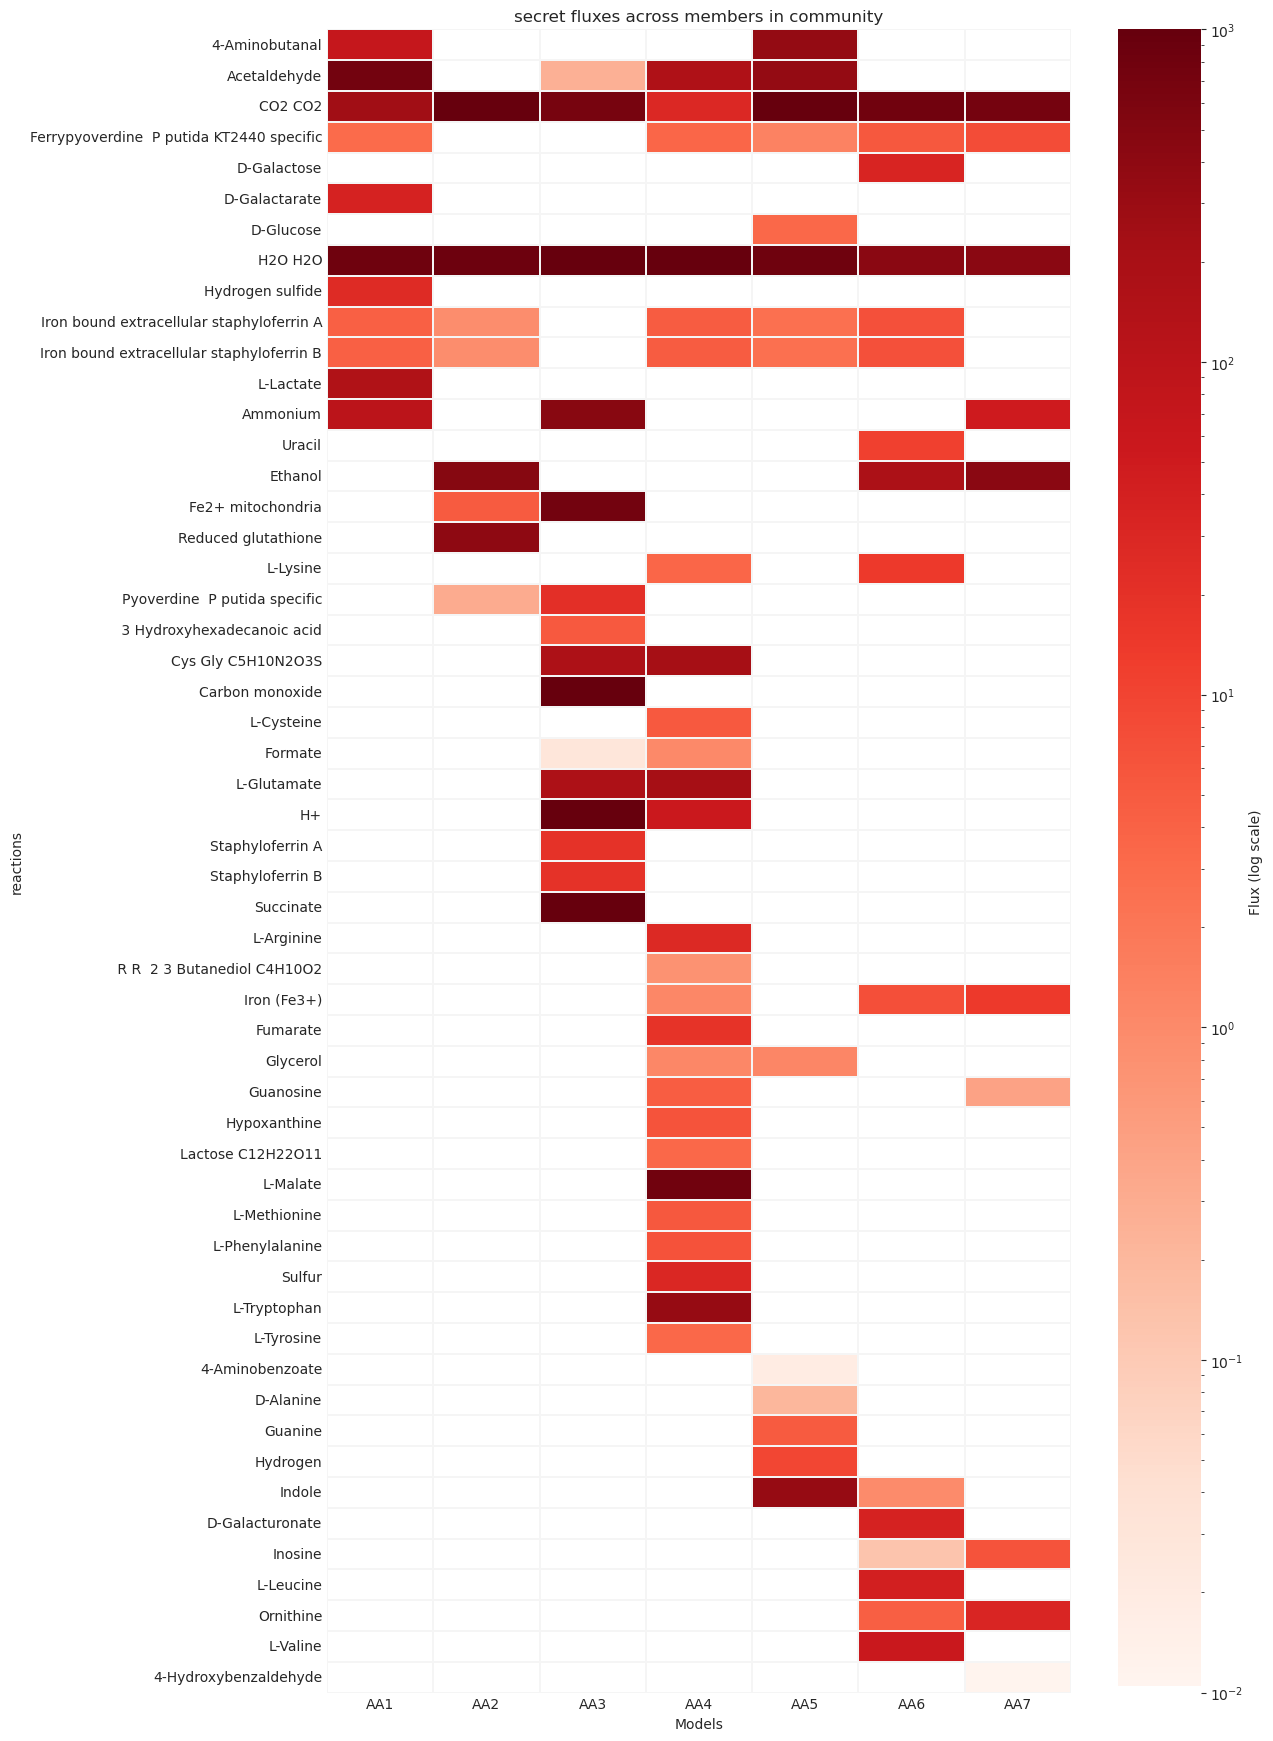

In [18]:
heatmap_fluxes_withinCommunity(syncom_filled, models_filled, medium_combined_krumbach, "secret", vmin=0.01)

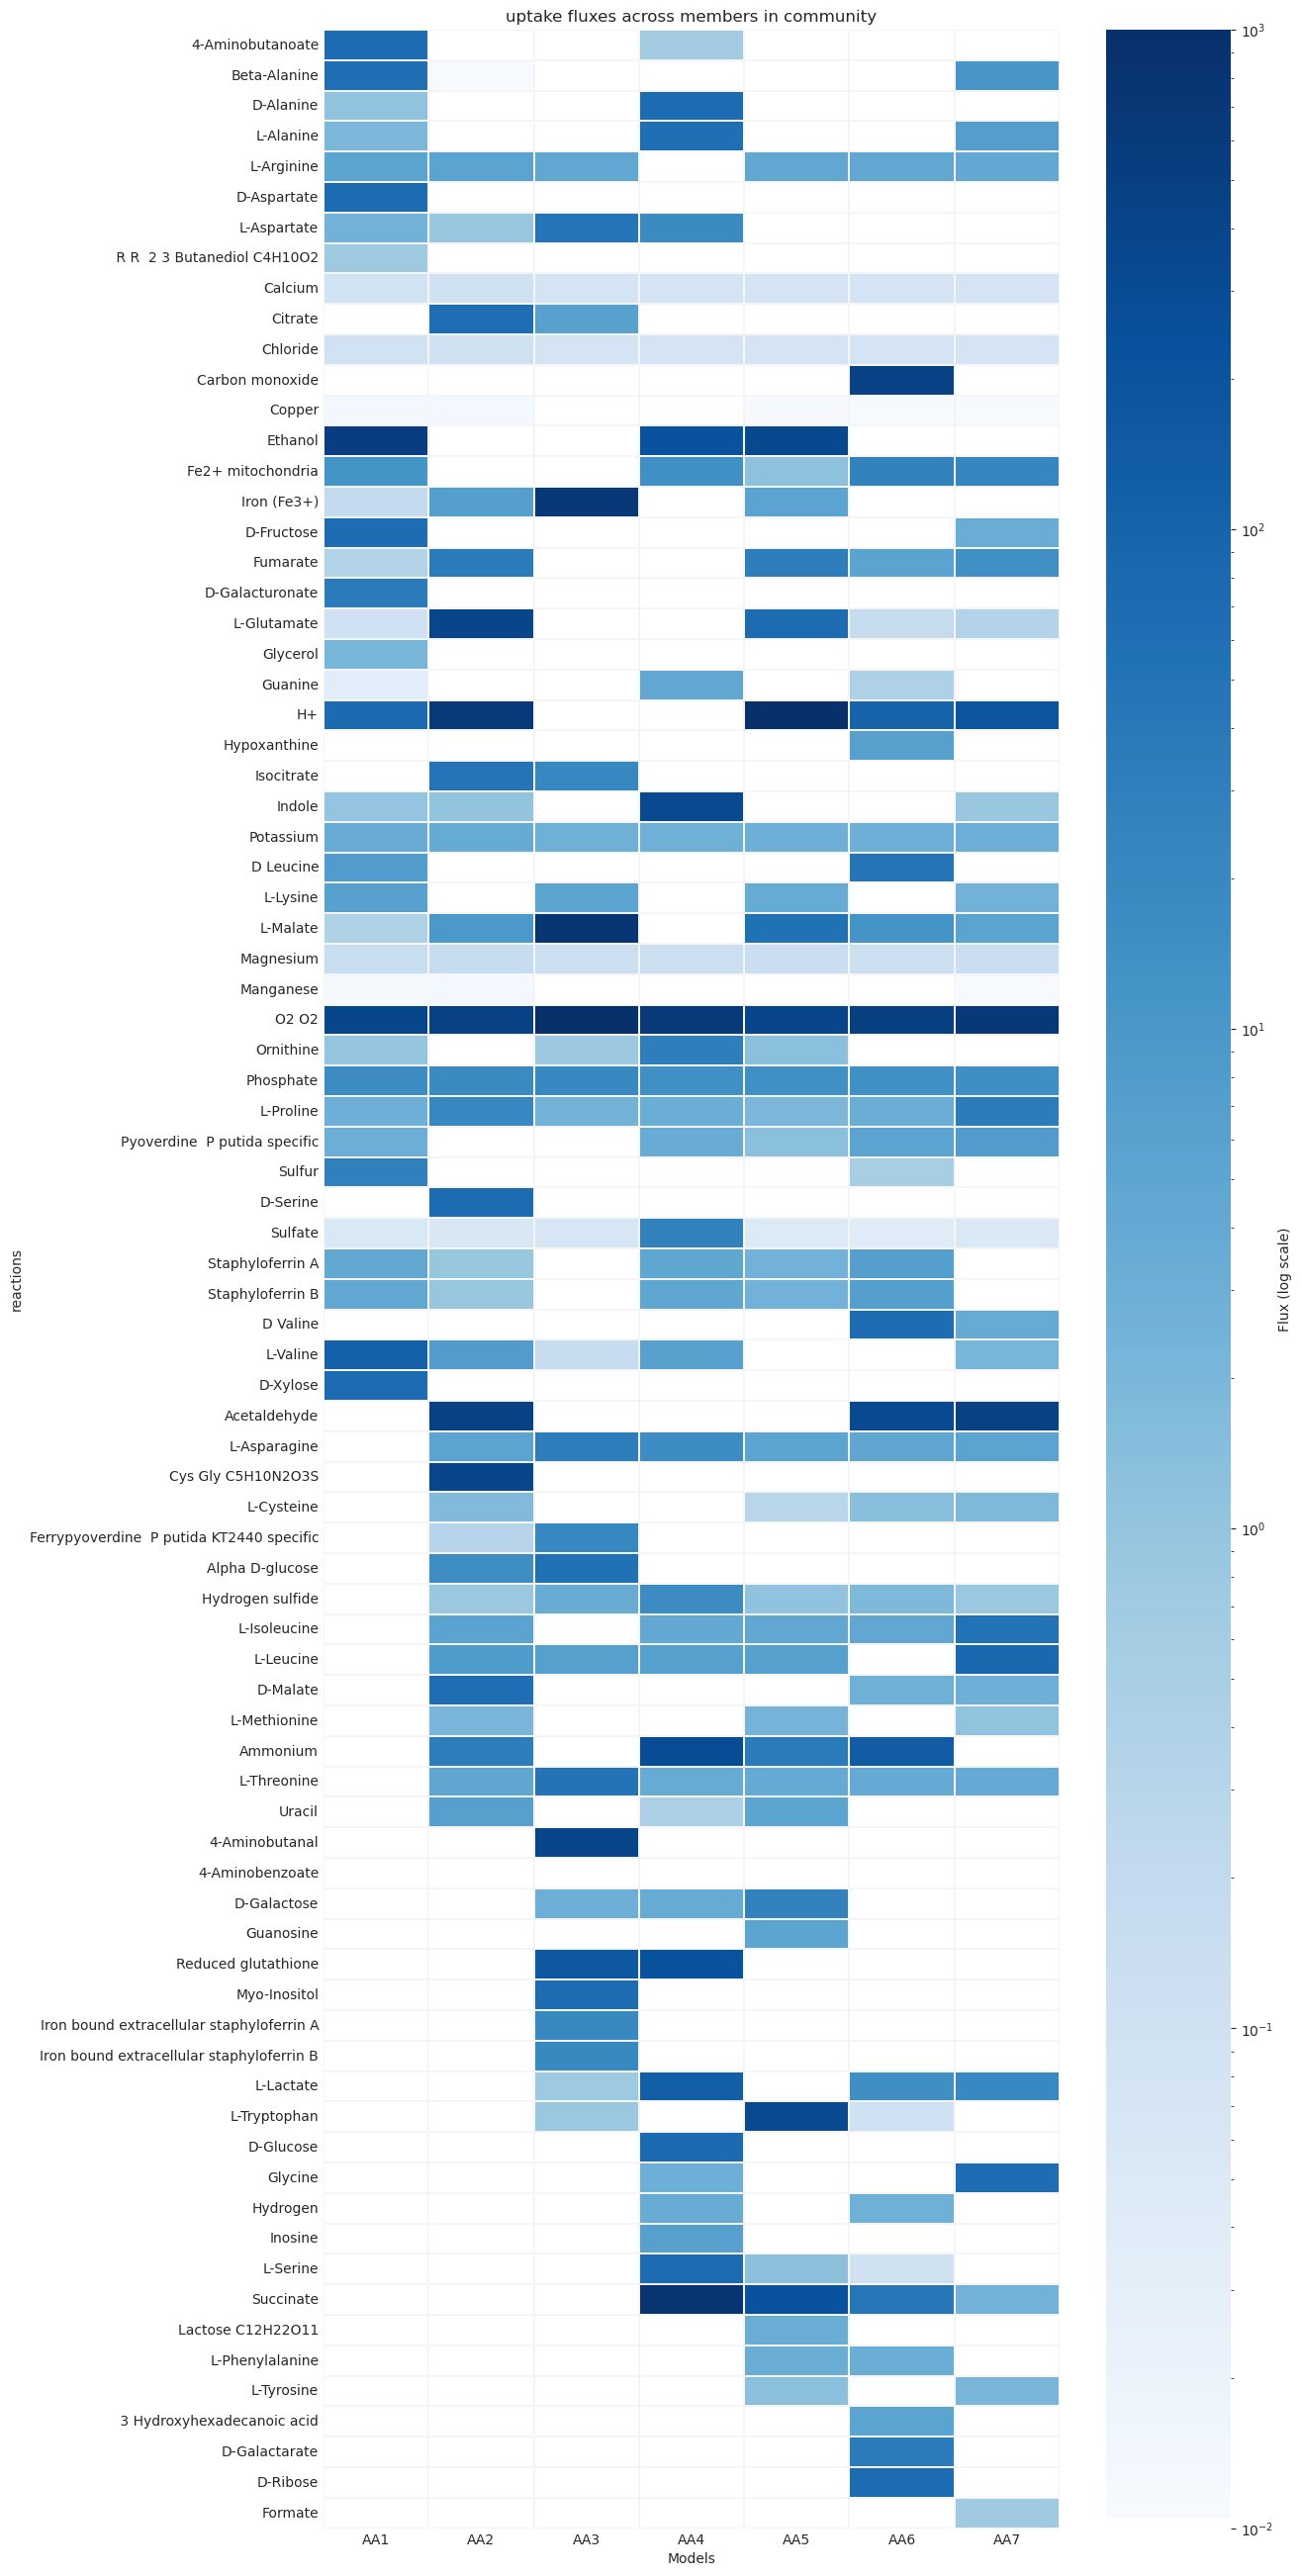

In [100]:
df_uptakes = heatmap_fluxes_withinCommunity(syncom_filled, models_filled, medium_combined_krumbach, "uptake", vmin=0.01)

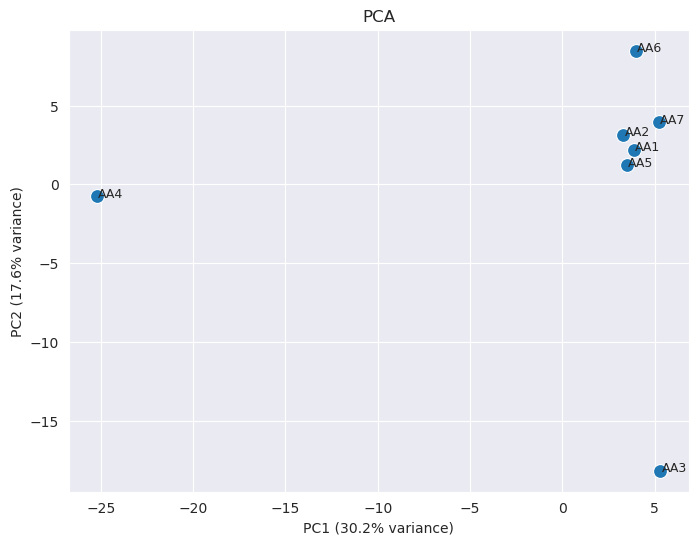

In [43]:
pca(df_uptakes.T)

# Visualisations

In [ ]:
from pyvis.network import Network

def visualise_network(model, medium, rxn_list, file_name):
    with model:
        change_medium(model, medium)
        com_fluxes = pfba(model).fluxes
    com_fluxes = com_fluxes.rename("flux").reset_index().rename(columns={"index": "reaction"})
    rxns = set(rxn_list)  # specify list of reactions that you want to visualise, e.g. ["rxn1", "rxn2", ...]
    net = Network(height="700px", width="100%", notebook=True, directed=True)

    for rxn in model.reactions:
        if rxn.id in rxns:

            flux = com_fluxes.loc[com_fluxes["reaction"] == rxn.id, "flux"].values[0]

            # Logarithmic scaling for edge width
            scaling_factor = 5
            if abs(flux) > 1e-6:
                width = min(max(np.log10(abs(flux) + 1) * scaling_factor, 1.5), 15.0)
            else:
                width = 1.0
            print(rxn.id, width)

            # Add reactants → reaction node
            for met in rxn.reactants:
                #net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_node(rxn.id, label=rxn.id, color="red", shape="box")
                #net.add_edge(met.id, rxn.id, color='black')  # reactant edges
            # Add reaction node → products
            for met in rxn.products:
                net.add_node(met.id, label=met.id, color="lightblue", shape="ellipse")
                net.add_edge(met.id, rxn.id, color='black', width=width)  # product edges

    # this file is exported and then can be opened and examined your browser)
    net.show(file_name)
    print(f"File saved.")


### Phylo visualisation

In [ ]:
from Bio import Phylo
import matplotlib.pyplot as plt

tree = Phylo.read("../phyliptree.phy", "newick")

fig = plt.figure(figsize=(12, 8))  # bigger figure helps
ax = fig.add_subplot(1, 1, 1)

Phylo.draw(tree, do_show=False, axes=ax)

plt.tight_layout()  # tries to optimize spacing
plt.show()


In [ ]:
from Bio import Phylo
import matplotlib.pyplot as plt

# Read your tree (make sure it's in a supported format)
tree = Phylo.read("../phyliptree.phy", "newick")

# Plot the tree
Phylo.draw(tree)
plt.show()


In [ ]:
from ete3 import Tree

# Load the tree from your .phy file
t = Tree("../phyliptree.phy", format=1)

# Show interactive tree viewer
t.show()


## Poster visualisations
Plots that were designed specifically for my poster for the MPA conference in Vienna; because they have to fit the poster maybe not all the infotmation is displayed that I normally would do or that I have done with my plots earlier in this notebook.

In [27]:
def filter_dataframe(df, threshold):
    # set values below the threshold to NaN
    filtered = df.where(df >= threshold)
    # drop rows where **all** values are NaN (i.e., all were below threshold)
    filtered = filtered.dropna(how='all')
    return filtered

In [28]:
threshold = 0.1

In [35]:
# get uptake fluxes only for our 7 models withput community
data = {}

for model_name, model_obj in models.items():
    medium = minimal_medium(model_obj, 2)
    medium = medium.rename("bound").reset_index().rename(columns={"index": "reaction"})
    flux_dict = get_fluxes_for_heatmap(model_obj, medium, type="uptake", c7_all_ex="yes", dict_with_rxn="yes")


    flux_dict_sorted = {}
    # this is mostly if we would use community to change reaction names that community has the same as the individuals
    # attention (if relevant in the future): this overwrites flux values because EX_met1_e_AA1 is the same aus EX_met1_e_AA2
    for rxn_id, flux in flux_dict.items():
        # Rule 1: Remove '__AA[1-7]' suffix if present
        if re.search(r'__(AA[1-7])$', rxn_id):
            clean_id = re.sub(r'__(AA[1-7])$', '', rxn_id)
        # Rule 2: If ends with '_m', replace it with '_e'
        elif rxn_id.endswith('_m'):
            clean_id = rxn_id[:-2] + '_e'
        else:
            clean_id = rxn_id

        flux_dict_sorted[clean_id] = flux

    data[model_name] = flux_dict_sorted

df = pd.DataFrame(data).fillna(0)
df = df.abs()
df = df.replace(0, np.nan)

df_uptakes_poster = filter_dataframe(df, threshold=threshold)

In [36]:
data = {}

for model_name, model_obj in models.items():
    medium = minimal_medium(model_obj, 2)
    medium = medium.rename("bound").reset_index().rename(columns={"index": "reaction"})
    flux_dict = get_fluxes_for_heatmap(model_obj, medium, type="secret", c7_all_ex="yes", dict_with_rxn="yes")

    flux_dict_sorted = {}
    for rxn_id, flux in flux_dict.items():
        flux_dict_sorted[rxn_id] = flux

    data[model_name] = flux_dict_sorted

df = pd.DataFrame(data).fillna(0)
df = df.abs()
df = df.replace(0, np.nan)

df_secrets_poster = filter_dataframe(df, threshold=threshold)

<Axes: >

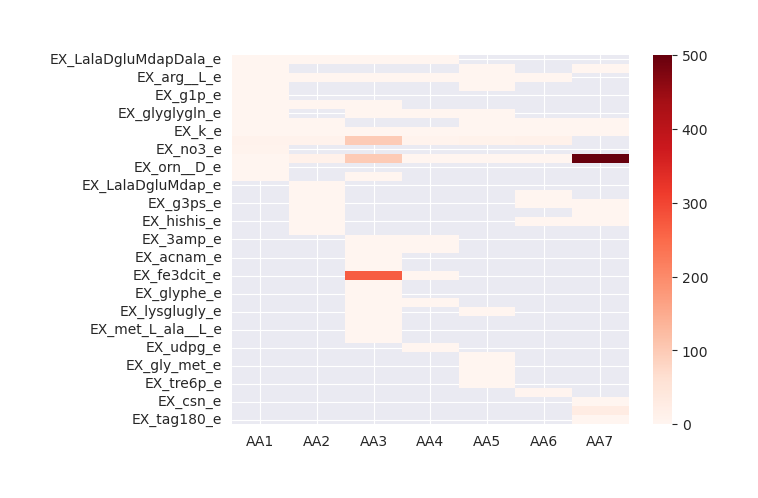

In [170]:
sns.heatmap(df_uptakes_poster, cmap="Reds")

### Upset Plot

In [26]:
# rename cols so they show up as the labels
name_changes = {"AA1": "Sma",
                   "AA2": "Bpi",
                   "AA3": "Cpu",
                   "AA4": "Elu",
                   "AA5": "Cin",
                   "AA6": "Hro",
                   "AA7": "Ppu"}

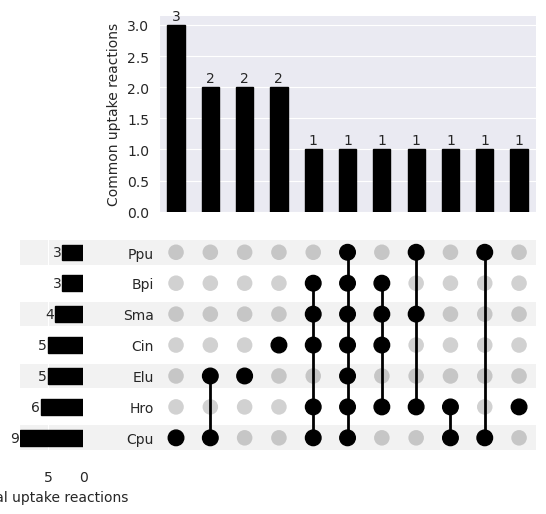

In [37]:
# Make boolean matrix: True = uptake present
bool_df = df_secrets_poster.notna()
bool_df = bool_df.rename(columns=name_changes)

# Convert to UpSet input format (multi-index of species presence)
upset_data = from_indicators(bool_df)

# Plot
upset = UpSet(
    upset_data,
    subset_size='count',
    show_counts=True,
    sort_by='cardinality'  # Sort by size of overlap (descending)
).plot()

plt.gca().set_ylabel("Common uptake reactions")
upset["totals"].set_xlabel("Total uptake reactions")

#plt.savefig("../Figures/upset_niches.svg", format="svg", bbox_inches="tight")
plt.show()


In [293]:
from matplotlib.patches import Patch

def plot_fluxes(df_uptake, df_secretion, model_name, threshold=threshold):
    # Rename model_name for display
    display_name = name_changes.get(model_name, model_name)

    # Get the model object (e.g. AA1) to extract metabolite names
    model = models[model_name]

    # Get and filter fluxes
    uptake = df_uptake[model_name].dropna()
    uptake = uptake[uptake.abs() > threshold]

    secretion = df_secretion[model_name].dropna()
    secretion = secretion[secretion.abs() > threshold]
    secretion = -abs(secretion)

    # Create a combined DataFrame with flux values and labels
    combined = pd.concat([uptake, secretion])
    flux_type = ['uptake'] * len(uptake) + ['secretion'] * len(secretion)
    combined_df = pd.DataFrame({'flux': combined, 'type': flux_type})

    # Sort by absolute flux value
    combined_df['abs_flux'] = combined_df['flux'].abs()
    combined_df = combined_df.sort_values(by='abs_flux', ascending=False)

    # Get metabolite names
    def get_met_name(rid):
        rxn = model.reactions.get_by_id(rid)
        return list(rxn.metabolites.keys())[0].name

    x_labels = [get_met_name(rid) for rid in combined_df.index]

    # Set colors
    color_map = {'uptake': 'mediumseagreen', 'secretion': 'orange'}
    bar_colors = [color_map[t] for t in combined_df['type']]

    # Plot
    plt.figure(figsize=(10,6))
    plt.bar(range(len(combined_df)), combined_df['flux'], color=bar_colors)

    plt.axhline(0, color='black', linewidth=0.8)
    plt.ylabel('log-scaled flux [mmol/(gDW h)]')
    plt.title(f'Uptake (positive) and Secretion (negative) fluxes for {display_name}')

    plt.xticks(ticks=range(len(combined_df)), labels=x_labels, rotation=45, ha='right')
    plt.yscale('symlog', linthresh=threshold)
    plt.ylim(combined_df['flux'].min() - 50, combined_df['flux'].max() + 10)

    # Add legend
    legend_elements = [
        Patch(facecolor='mediumseagreen', label='Uptake'),
        Patch(facecolor='orange', label='Secretion')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.tight_layout()
    plt.savefig(f"../Figures/fluxes_{display_name}.svg", format="svg", bbox_inches="tight")
    plt.show()


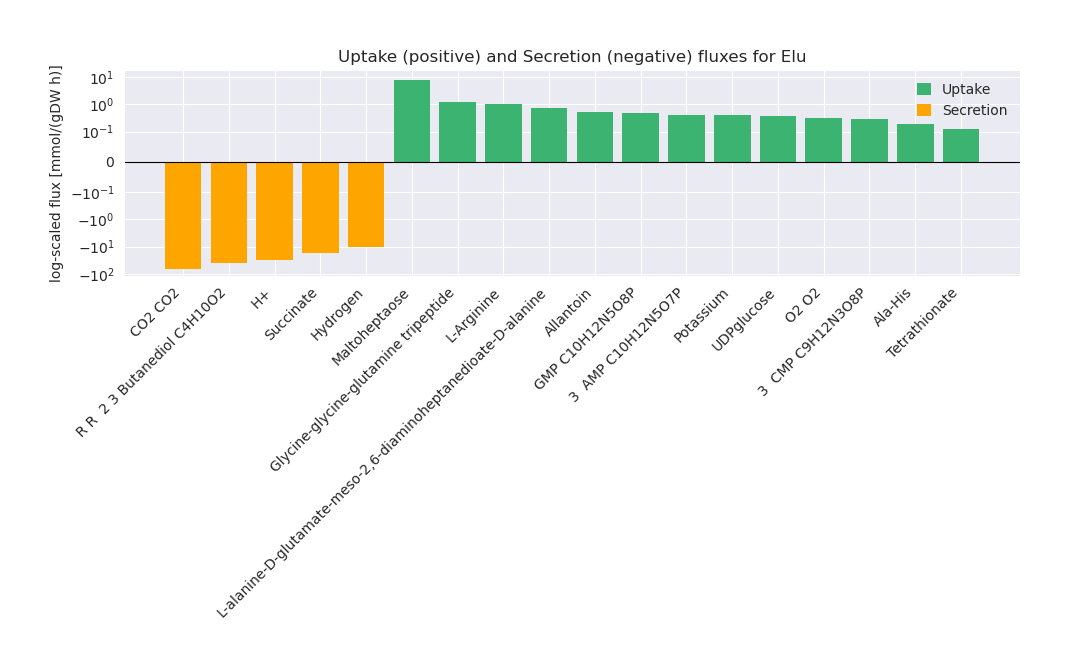

In [294]:
plot_fluxes(df_uptakes_poster, df_secrets_poster, "AA4")

# Spielplatz

AA7 can grow on water and M9??

In [38]:
minimal_medium(AA7f, minimize_components=True)

EX_bz_e           0.00001
EX_ca2_e          0.00052
EX_cl_e           0.00052
EX_cobalt2_e      0.00001
EX_cu_e           0.00007
EX_g3ps_e      1000.00000
EX_istfrnA_e      0.00150
EX_k_e            0.01952
EX_mg2_e          0.00087
EX_mn2_e          0.00007
EX_o2_e         999.48997
EX_tsul_e         0.01256
EX_zn2_e          0.00003
dtype: float64

In [46]:
for rxn in m9_rxn:
    for met in AA7f.reactions.get_by_id(rxn).metabolites:
        print(met.formula)

Na
HO4P
H4N
Cl
K
H
Mg
O4S
Ca
Fe
Fe
Mn
Zn
MoO4
O2
Cu
Co
C7H5O2
